In [29]:
import os
import cv2
import seaborn as sn 
import matplotlib.pyplot as plt
import tensorflow as tf
from tensorflow import keras
from tensorflow.keras import layers
import random
import numpy as np
import glob as glob
from sklearn.model_selection import train_test_split
import csv
import pandas as pd
from sklearn.metrics import confusion_matrix, classification_report  
from sklearn.metrics import balanced_accuracy_score
from sklearn.metrics import f1_score
from sklearn.metrics import roc_auc_score
from sklearn.utils import class_weight
from tensorflow.keras.utils import to_categorical
from tensorflow.keras.applications.vgg16 import VGG16
from tensorflow.keras.applications.vgg16 import preprocess_input
from keras.applications.vgg19 import VGG19
from sklearn.metrics import f1_score
from sklearn.metrics import roc_auc_score
from sklearn.model_selection import cross_val_score
from sklearn.model_selection import KFold

In [2]:
color = 'rgb' #'grayscale' o 'rgb'

escala = 150

In [3]:
def cargar_datos(path1, path2, escala = escala, color = color):
    
    EMD = os.listdir(path1)
    NO_EMD = os.listdir(path2)
    
    data = []
    labels = []

    for i in EMD:   
        image=tf.keras.preprocessing.image.load_img(path1+'/'+i, color_mode= color, 
        target_size= (escala, escala))
        image=np.array(image)
        data.append(image)
        labels.append(1)
    for i in NO_EMD:   
        image=tf.keras.preprocessing.image.load_img(path2+'/'+i, color_mode= color, 
        target_size= (escala, escala))
        image=np.array(image)
        data.append(image)
        labels.append(0)
        
    data = np.array(data)
    labels = np.array(labels)
    
    return data, labels

In [4]:
dataset_iphone = cargar_datos('Datos preprocesados EMD/iPhone/EMD', 'Datos preprocesados EMD/iPhone/NO EMD')

In [5]:
dataset_samsung = cargar_datos('Datos preprocesados EMD/Samsung/EMD', 'Datos preprocesados EMD/Samsung/NO EMD')

In [6]:
dataset = cargar_datos('Datos preprocesados EMD/OCT/EMD', 'Datos preprocesados EMD/OCT/NO EMD')

### TRAIN: OCT + Samsung

### TEST: iPhone

In [7]:
train_ds = np.concatenate((dataset[0],dataset_samsung[0]))

train_labels = np.concatenate((dataset[1],dataset_samsung[1]))

In [8]:
test_ds = dataset_iphone[0]

test_labels = dataset_iphone[1]

In [9]:
train_labels_categorical = to_categorical(train_labels, num_classes=2)
test_labels_categorical = to_categorical(test_labels, num_classes=2)

In [10]:
## Loading VGG16 model
base_model = VGG19(weights="imagenet", include_top=False, input_shape=train_ds[0].shape)
base_model.trainable = False ## Not trainable weights

## Preprocessing input
train_ds = preprocess_input(train_ds) 
test_ds = preprocess_input(test_ds)

In [11]:
from tensorflow.keras import layers, models

flatten_layer = layers.Flatten()
dense_layer_1 = layers.Dense(50, activation='relu')
dense_layer_2 = layers.Dense(20, activation='relu')
prediction_layer = layers.Dense(2, activation='softmax')


model = models.Sequential([
    base_model,
    flatten_layer,
    dense_layer_1,
    dense_layer_2,
    prediction_layer
])

In [12]:
classes = np.unique(train_labels)

class_weights = class_weight.compute_class_weight('balanced', classes=classes, y=train_labels)

dic_class_weights = {0:class_weights[0], 1:class_weights[1]}

In [13]:
from tensorflow.keras.callbacks import EarlyStopping

model.compile(
    optimizer='adam',
    loss='categorical_crossentropy',
    metrics=['accuracy'],
)

es = EarlyStopping(monitor='val_accuracy', mode='max', patience=20,  restore_best_weights=True)

history = model.fit(train_ds, train_labels_categorical, epochs=200, validation_split=0.2, batch_size=32, callbacks=[es], class_weight=dic_class_weights)

Epoch 1/200
6/6 [==============================] - 13s 2s/step - loss: 7.2530 - accuracy: 0.5876 - val_loss: 19.0513 - val_accuracy: 0.0000e+00
Epoch 2/200
6/6 [==============================] - 11s 2s/step - loss: 2.0169 - accuracy: 0.6384 - val_loss: 1.0677 - val_accuracy: 0.7333
Epoch 3/200
6/6 [==============================] - 14s 2s/step - loss: 1.5366 - accuracy: 0.7062 - val_loss: 7.8751 - val_accuracy: 0.1111
Epoch 4/200
6/6 [==============================] - 15s 3s/step - loss: 1.1776 - accuracy: 0.8079 - val_loss: 7.5108 - val_accuracy: 0.1111
Epoch 5/200
6/6 [==============================] - 15s 3s/step - loss: 0.6737 - accuracy: 0.7345 - val_loss: 7.0855 - val_accuracy: 0.1333
Epoch 6/200
6/6 [==============================] - 16s 3s/step - loss: 0.4668 - accuracy: 0.8927 - val_loss: 7.8274 - val_accuracy: 0.1111
Epoch 7/200
6/6 [==============================] - 16s 3s/step - loss: 0.2090 - accuracy: 0.9040 - val_loss: 3.5000 - val_accuracy: 0.4222
Epoch 8/200
6/6 [=====

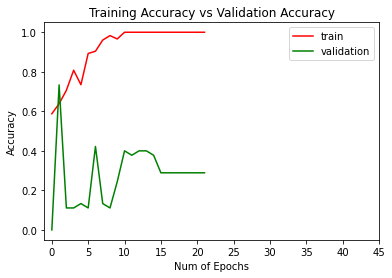

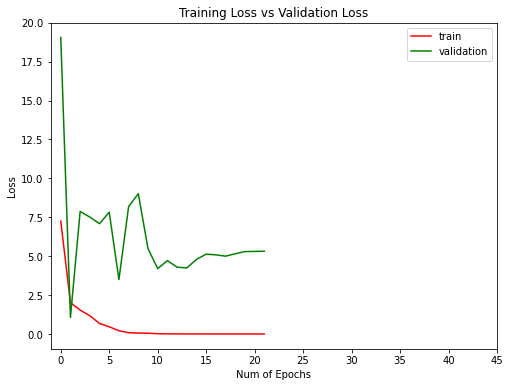

In [15]:
plt.figure(0)  
plt.plot(history.history['accuracy'],'r')  
plt.plot(history.history['val_accuracy'],'g')  
plt.xticks(np.arange(0, 50, 5.0))  
plt.rcParams['figure.figsize'] = (8, 6)  
plt.xlabel("Num of Epochs")  
plt.ylabel("Accuracy")  
plt.title("Training Accuracy vs Validation Accuracy")  
plt.legend(['train','validation'])

plt.figure(1)  
plt.plot(history.history['loss'],'r')  
plt.plot(history.history['val_loss'],'g')  
plt.xticks(np.arange(0, 50, 5.0))  
plt.rcParams['figure.figsize'] = (8, 6)  
plt.xlabel("Num of Epochs")  
plt.ylabel("Loss")  
plt.title("Training Loss vs Validation Loss")  
plt.legend(['train','validation'])

plt.show() 

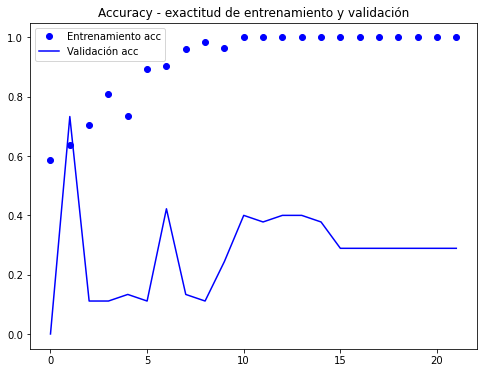

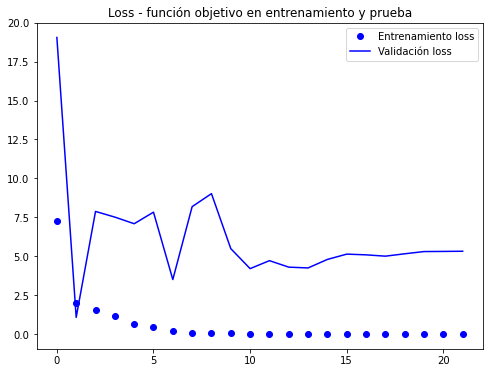

In [16]:
acc      = history.history['accuracy']
val_acc  = history.history['val_accuracy']
loss     = history.history['loss']
val_loss = history.history['val_loss']

epochs = range(len(acc))

plt.plot(epochs, acc, 'bo', label='Entrenamiento acc')
plt.plot(epochs, val_acc, 'b', label='Validación acc')
plt.title('Accuracy - exactitud de entrenamiento y validación')
plt.legend()

plt.figure()

plt.plot(epochs, loss, 'bo', label='Entrenamiento loss')
plt.plot(epochs, val_loss, 'b', label='Validación loss')
plt.title('Loss - función objetivo en entrenamiento y prueba')
plt.legend()

plt.show()

4/4 [==============================] - 7s 2s/step


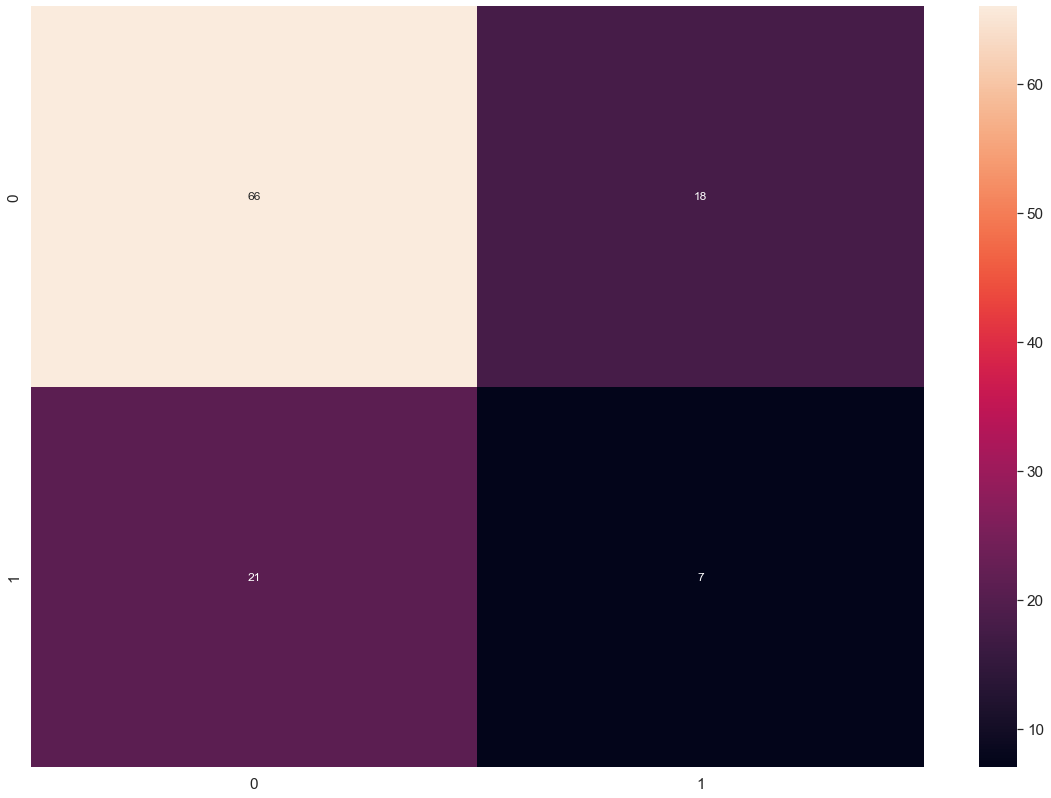

In [17]:
vgg16 = model.predict(test_ds, batch_size=32, verbose=1)  
vgg16_predicted = np.argmax(vgg16, axis=1)

vgg_cm = confusion_matrix(np.argmax(test_labels_categorical, axis=1), vgg16_predicted)

# Visualizing of confusion matrix
vgg_df_cm = pd.DataFrame(vgg_cm, range(2), range(2))  
plt.figure(figsize = (20,14))  
sn.set(font_scale=1.4) #for label size  
sn.heatmap(vgg_df_cm, annot=True, annot_kws={"size": 12}) # font size  
plt.show() 

**MÉTRICAS DE EVALUACIÓN**

In [14]:
score_test = model.evaluate(x=test_ds, y=test_labels_categorical, verbose = 0)

print("Test loss:", score_test[0])
print("Test accuracy:", score_test[1])

Test loss: 1.7951172590255737
Test accuracy: 0.6517857313156128


In [18]:
predictions = model.predict(test_ds)

4/4 [==============================] - 7s 2s/step


In [19]:
roc_score = roc_auc_score(test_labels_categorical, predictions, multi_class='ovr')

print(roc_score)

0.5331632653061225


In [20]:
snn_predicted = np.argmax(predictions, axis=1)
snn_report = classification_report(np.argmax(test_labels_categorical, axis=1), snn_predicted)  
print(snn_report)

              precision    recall  f1-score   support

           0       0.76      0.79      0.77        84
           1       0.28      0.25      0.26        28

    accuracy                           0.65       112
   macro avg       0.52      0.52      0.52       112
weighted avg       0.64      0.65      0.64       112



**Validación cruzada**

In [30]:
kf = KFold(n_splits=5)

scores = cross_val_score(model, train_ds, train_labels, cv=kf, scoring="accuracy")

TypeError: Cannot clone object '<keras.engine.sequential.Sequential object at 0x0000026BA3B68A60>' (type <class 'keras.engine.sequential.Sequential'>): it does not seem to be a scikit-learn estimator as it does not implement a 'get_params' method.